# 10-sat_image_analysis_script

This notebook is a simplified version of script 17-sat_image_analysis.py (Updated up until Dec 11 2023)

It allows us to __run 1 city__ and 1 resolution in order to spot and debug errors.

## Import libraries

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

In [2]:
# Set raster spectral bands and analysis equation
band_name_dict = {'nir':[False], #If GSD(resolution) of band is different, set True.
                  'red':[False], #If GSD(resolution) of band is different, set True.
                  'eq':['(nir-red)/(nir+red)']}

# Set analysis name
index_analysis = 'ndvi'

# Set directory to save analysed rasters
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [8] #JUST ONE since it is for trials, if many needed use script or edit notebook

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2018-01-01'
end_date = '2022-12-31'

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
sat_query = {"eo:cloud_cover": {"lt": 10}}

# Del rasters after processing.
del_data = False # True

# Save?
save = True #------ Set True if full analysis

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'SLP'

## 01 - Load Area of interest

<Axes: >

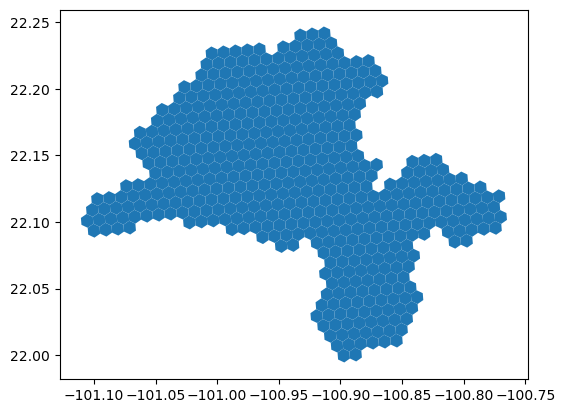

In [3]:
### Create city area of interest with biggest hexs
big_res = min(res)
schema_hex = 'hexgrid'
table_hex = f'hexgrid_{big_res}_city_2020'

# Download hexagons with type=urban
type = 'urban'
query = f"SELECT hex_id_{big_res},geometry FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}\' AND \"type\" = '{type}\'"
hex_urban = aup.gdf_from_query(query, geometry_col='geometry')

# Download hexagons with type=rural within 500m buffer
poly = hex_urban.to_crs("EPSG:6372").buffer(500).reset_index()
poly = poly.to_crs("EPSG:4326")
poly_wkt = poly.dissolve().geometry.to_wkt()[0]
type = 'rural'
query = f"SELECT hex_id_{big_res},geometry FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}\' AND \"type\" = '{type}\' AND (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
hex_rural = aup.gdf_from_query(query, geometry_col='geometry')

# Concatenate urban and rural hex
hex_city = pd.concat([hex_urban, hex_rural])

aup.log(f'Downloaded {len(hex_city)} hexagon features')

# Show
hex_city.plot()

## 02 - Download and process rasters

In [ ]:
### Download and process rasters
df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, start_date, end_date, 
                                     tmp_dir, band_name_dict, query = sat_query, satellite = satellite)

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
  0%|                                                                                         | 0/60 [00:00<?, ?it/s]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
  2%|█▎                                                                            | 1/60 [04:13<4:08:50, 253.07s/it]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


### 02 Debug

Debugging function
* aup.download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, 
                        tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a")

In [5]:
# Base data for function download_raster_from_pc
gdf = hex_city.copy()
query = sat_query

In [6]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:6372").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

date_list = aup.available_datasets(items, satellite)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Fetched 520 items
Created dictionary from items


In [7]:
# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
aup.available_data_check(df_len, missing_months) # test for missing months

# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
pct_missing = round(missing_months/len(df_len),2)*100

# if more than 50% of data is missing, raise error and print message
if pct_missing >= 50:

    raise AvailableData('Missing more than 50 percent of data points')

# raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
print('Created bounding box for raster cropping')

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

Created bounding box for raster cropping


In [ ]:
# raster creation
print('Starting raster creation for specified time')
# download raster data by month
#create_raster_by_month(df_len, index_analysis, city, tmp_dir, 
#                       band_name_dict, date_list, gdf_raster_test, gdf_bb, 
#                       aoi, sat, query={}, time_exc_limit=1500)

df_len = aup.create_raster_by_month(df_len, index_analysis, city, tmp_dir,
                                    band_name_dict, date_list, gdf_raster_test,
                                    gdf_bb, area_of_interest, satellite, query=query)
print('Finished raster creation')

Starting raster creation for specified time


  0%|                                                                                         | 0/60 [00:00<?, ?it/s]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


## 03 - Create hexgrids

In [ ]:
# Create res_list
res_list=[]
for r in range(res[0],res[-1]+1):
    res_list.append(r)

# Load hexgrids
hex_gdf = hex_city.copy()
hex_gdf.rename(columns={f'hex_id_8':'hex_id'}, inplace=True)
hex_gdf['res'] = 8

print(f'Loaded hexgrid res 8')

for r in res_list:
    # biggest resolution already loaded
    if r == 8:
        continue
    # Load hexgrid
    table_hex = f'hexgrid_{r}_city_2020'
    query = f"SELECT hex_id_{r},geometry FROM {schema_hex}.{table_hex} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    # Format hexgrid
    hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
    hex_tmp['res'] = r
    # Concatenate to hex_gdf
    hex_gdf = pd.concat([hex_gdf, hex_tmp])

    print(f'Loaded hexgrid res {r}')

    del hex_tmp

In [ ]:
# NOT IN SCRIPT - Since this notebook allows us to run trials it keeps 1 resolution specified in res
hex_gdf = hex_gdf.loc[hex_gdf.res == res[0]]
hex_gdf.res.unique()

## 04 - Process and save data

In [ ]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    print(f'Translating raster to hexagon for res: {r}')
    
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)
    print('Finished assigning raster data to hexagons')
    print(f'df nan values: {df_raster_analysis[index_analysis].isna().sum()}')
    if df_raster_analysis[index_analysis].isna().sum() > 0:
        raise NanValues('NaN values are still present after processing')
    
    # local save (test)
    if local_save:
        # Create folder to store local save
        localsave_dir = tmp_dir+'local_save/'
        if os.path.exists(localsave_dir) == False:
            os.mkdir(localsave_dir)
    
        # Local save
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

    # Save - upload to database
    if save:
        upload_chunk = 150000
        print(f'Starting upload for res: {r}')

        if r == 8:
            # df upload
            aup.df_to_db_slow(df_raster_analysis, f'{index_analysis}_complete_dataset_hex',
                            'raster_analysis', if_exists='append', chunksize=upload_chunk)
            # gdf upload
            aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                            'raster_analysis', if_exists='append')

        else:
            # df upload
            limit_len = 5000000
            if len(df_raster_analysis)>limit_len:
                c_upload = len(df_raster_analysis)/limit_len
                for k in range(int(c_upload)+1):
                    print(f"Starting range k = {k} of {int(c_upload)}")
                    df_inter_upload = df_raster_analysis.iloc[int(limit_len*k):int(limit_len*(1+k))].copy()
                    aup.df_to_db(df_inter_upload,f'{index_analysis}_complete_dataset_hex',
                                    'raster_analysis', if_exists='append')
            else:
                aup.df_to_db(df_raster_analysis,f'{index_analysis}_complete_dataset_hex',
                                    'raster_analysis', if_exists='append')
            # gdf upload
            aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                            'raster_analysis', if_exists='append')
        print(f'Finished uploading data for res{r}')
        
    # delete variables
    del df_raster_analysis
    del hex_raster_analysis

In [ ]:
for r in list(hex_gdf.res.unique()):

    print(f'---------------------------------------')
    print(f'STARTING processing for resolution {r}.')

    processing_chunk = 100000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)

    if len(hex_gdf_res)>processing_chunk:
        print(f'hex_gdf_res len: {len(hex_gdf_res)} is bigger than processing chunk: {processing_chunk}')
        c_processing = len(hex_gdf_res)/processing_chunk
        print(f'There are {round(c_processing)} processes')
        for i in range(int(c_processing)+1):
            print(f'Processing from {i*processing_chunk} to {(i+1)*processing_chunk}')
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)

    else:
        print('hex_gdf len smaller than processing chunk')
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

print(f'Finished processing city -- {city}')
del hex_gdf

if del_data:
    # delete raster files
    aup.delete_files_from_folder(tmp_dir)